# Capstone Project - The battle of the flavours (Week 5) Complete Report
### Applied Data Science Capstone by IBM/Coursera

## Table of contents

* **[1. Introduction: Business Case](#Introduction:BusinessCase)**
* **[2. Data](#Data)**
* **[3. Methodology](#Methodology)**
* **[4. Analysis](#Analysis)**
* **[5. Results and Discussion](#Results)**
* **[6. Conclusions](#Conclusions)**



## 1. Introduction: Business Case <a name="introduction"></a>

In this project we want to idenfify the best location to craft-beer shop around Madrid downtown. Recently many people turned back their taste preferences to these products looking for healthier food and authentic flavours which have been put aside by the industrialized food companies.

This kind of shops have the favour of the public, specially those people with ages around between the thirties to fourties.

The shop will be something different as it targets to sell a highly valuable product for the Spanish population.

We will use data got from the different Madrid downtown districts **to find the most suitable location for the shop inside a 3km circle from Madrid City Center**, based on the similar shops around a distance of 500m, and the ages distribution of the living population in those districts, **targeting people between a Young Index between de 25% and 75% percentiles**.

Also **the price per square meter** from the different above selected districts, looking for the cheapest one to open the shop as the final criteria to select a place.

## 2. Data <a name="Data"></a>

Based on definition of our problem, factors that will influence our decision are:

* Number of existing craft-beer shops in the neighborhood / district.
* Distance to  other craft-beer shops in the neighborhood or district, if any.
* Age distribution in the districts
* Price in euros per square meter of the houses or shops in the districts, real-state.

Following data sources will be needed to extract/generate the required information:
* Centers of districts will be generated algorithmically and approximate addresses of centers of those areas will be obtained using **Geocoder Python Library** 

https://geocoder.readthedocs.io/index.html

* Number of craft-beer shops or similar venues in every neighborhood will be obtained using **Foursquare API**
* Coordinate of Madrid center will be obtained using **Geocoder Python Library** of well known Madrid location (Puerta del Sol).
* Housing prices and demographic information from Madrid districts will be got from Madrid´s city council web page:

https://www.madrid.es/portales/munimadrid/es/Inicio/El-Ayuntamiento/Estadistica/Areas-de-informacion-estadistica/Areas-de-informacion-estadistica/?vgnextfmt=default&vgnextoid=9023c9fa0b23a210VgnVCM2000000c205a0aRCRD&vgnextchannel=b65ef78526674210VgnVCM1000000b205a0aRCRD

* From the different excel files got from the city council web page, the information needed from the districts will be grouped and filtered for later use along with the geographical data and venues data in order to complete the business case analysis.


### Import Libraries needed for the Project

In [1]:
# Import all needed libraries
import os # System files movements
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library
import matplotlib as plt
import matplotlib.pyplot as plt

# Folium
!conda install -c conda-forge folium=0.5.0 --yes
import folium
print('Folium installed and imported!')
!pip install geocoder
import geocoder
!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
import geopy
!pip install geojson
print('Geopy, Geocoder, and geojson installed and imported!')

# Dependency needed to install file 
!pip install xlrd

import requests # library to handle requests
# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize
import geojson

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!pip install pyproj
import pyproj

import math

#!conda install -c conda-forge shapely --yes
#import shapely


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    numpy-1.17.3               |   py36h95a1406_0         5.2 MB  conda-forge
    scipy-1.4.1                |   py36h921218d_0        18.9 MB  conda-forge


### Load Data from Madrid's City Council
Relevant statistical information has been downloaded from Madrid's City Council, and arranged into one Excel file, which is going to be loaded as a pandas dataframe.

In [2]:
dfMadrid = pd.read_excel('Datos_Madrid_Capstone.xls',sheet_name='Data')
print('Data downloaded and read into a dataframe!')
dfMadrid.head()

Data downloaded and read into a dataframe!


,Distrito,Índice de juventud,ObraNueva (Eur/m2),ObraUsada (Eur/m2),lon,lat
0,Ciudad de Madrid,70.179326,2624.77,3387.14,-3.691944,40.418889
1,Centro,51.610072,4521.91,4817.37,-3.707371,40.415347
2,Arganzuela,65.438845,3670.25,3698.09,-3.695403,40.402733
3,Retiro,48.715364,3989.25,4457.96,-3.676729,40.408072
4,Salamanca,47.506659,5674.82,5398.93,-3.677778,40.430000


### District Candidates

Let's create latitude & longitude coordinates for centroids of our candidate neighborhoods. We will create a folium map covering our area of interest a **3km circle centered around Madrid city center (Puerta del Sol)**.

Let's first find the latitude & longitude of Madrid city center, using specific, well known address and Geocoder

### Read geojson districts geographical information downloaded from Github.

In [3]:
madrid_districts_geo = r'madrid-districts.geojson'  # Para leer el fichero geojson del directorio local.
print('GEOJSON file readed!')

GEOJSON file readed!


In [4]:
data_districts = pd.read_json('/resources/labs/DP0701EN/Capstone/madrid-districts.geojson')
#features = data_districts['features'][0]
#data_districts['features'][0]

In [5]:
#data_districts['features'][0]['geometry']['coordinates']
#lista_Coords_Centro = data_districts['features'][0]['geometry']['coordinates']
#lista_Coords_Centro[0][0][0] # Access to coordinates list from each point that defines the polygon around any district.

In [6]:
#lista_Coords_Centro = list(geojson.utils.coords(data_districts)) 
#len(lista_Coords_Centro[:])
#lista_Coords_Centro

### Foursquare
Now that we have our location candidates, let's use Foursquare API to get info on breweries in each neighborhood.
Foursquare code for brewery or "craft-beer" (in Spanish "Tienda de Cerveza").

In [7]:
!pip install foursquare
import foursquare

  Stored in directory: /home/jupyterlab/.cache/pip/wheels/53/6c/d9/0810f42ef7521037af97032caab9411144ab0efab2aed8300f
Successfully built foursquare


### Define Foursquare Credentials and Version

In [8]:
CLIENT_ID = 'FLZED3BEIVB5HLS3ZMJTNWBSFL3WL0QM4T1SVXW0YI3UU5A4' # your Foursquare ID
CLIENT_SECRET = 'W231AZOJUDH3JZGC4XKVZX215KE33DINLTCVSWZT2D3F11KN' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 50
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FLZED3BEIVB5HLS3ZMJTNWBSFL3WL0QM4T1SVXW0YI3UU5A4
CLIENT_SECRET:W231AZOJUDH3JZGC4XKVZX215KE33DINLTCVSWZT2D3F11KN


In [9]:
import geocoder
import geopy
address = 'Puerta del Sol, Madrid'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

40.4168654 -3.7043021694878


### Search for a specific venue category
> `https://api.foursquare.com/v2/venues/`**search**`?client_id=`**CLIENT_ID**`&client_secret=`**CLIENT_SECRET**`&ll=`**LATITUDE**`,`**LONGITUDE**`&v=`**VERSION**`&query=`**QUERY**`&radius=`**RADIUS**`&limit=`**LIMIT**

#### Search for Breweries or craft-beer shops **("Cervecerías in Spanish")**, some Foursquare codes for similar places

Cervecera
50327c8591d4c4b30a586d5d

Tienda de Cerveza
5370f356bcbc57f1066c94c2

We will perform three searches one per category, to get three dataframes which will be merged and cleaned later.

In [10]:
# 1. Search for 
search_query = 'craft-beer'
#search_query = 'beer'
categoryID = ['50327c8591d4c4b30a586d5d','5370f356bcbc57f1066c94c2']
radius = 5000 # 5km radius around center
print(search_query + ' .... OK!')

craft-beer .... OK!


In [11]:
# Loop through the categories ID to get three dataframes
url_0 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}&categoryID={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT,categoryID[0])
results_0 = requests.get(url_0).json() # Send the GET Request and examine the results
# Get relevant part of JSON and transform it into a *pandas* dataframe 
# assign relevant part of JSON to venues
cervecera = results_0['response']['venues']
# tranform venues into a dataframe
df_cervecera = json_normalize(cervecera)

url_1 = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}&categoryID={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT,categoryID[1])
results_1 = requests.get(url_1).json() # Send the GET Request and examine the results
# Get relevant part of JSON and transform it into a *pandas* dataframe 
# assign relevant part of JSON to venues
tienda_de_cerveza = results_0['response']['venues']
# tranform venues into a dataframe
df_tienda = json_normalize(tienda_de_cerveza)  

In [12]:
# Merge all together
dframes = [df_cervecera,df_tienda]
df_craftb = pd.concat(dframes, axis = 0)
df_craftb.head()

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.crossStreet,venuePage.id,location.neighborhood
0,5bf1a840ad910e002c4a046b,La Tienda De La Cerveza - Craft Beer Bar,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B...",v-1577436031,False,"Calle de las Maldonadas, 5",40.410942,-3.708029,"[{'label': 'display', 'lat': 40.410942, 'lng':...",731,28005,ES,Madrid,Madrid,España,"[Calle de las Maldonadas, 5, 28005 Madrid Madr...",NaN,NaN,NaN
1,5b087bb6b9a5a8002c3477cb,Sam Hop Craft Beer,"[{'id': '56aa371ce4b08b9a8d57356c', 'name': 'B...",v-1577436031,False,Calle De Lavapies,40.411468,-3.702996,"[{'label': 'display', 'lat': 40.411468, 'lng':...",610,28012,ES,Madrid,Madrid,España,"[Calle De Lavapies, 28012 Madrid Madrid, España]",NaN,NaN,NaN
2,5905bec2a4236221271945b2,Craft 19 - Craft Beer & Pastrami,"[{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...",v-1577436031,False,Calle de Vallehermoso 36,40.434100,-3.708280,"[{'label': 'display', 'lat': 40.4341, 'lng': -...",1947,28015,ES,Madrid,Madrid,España,[Calle de Vallehermoso 36 (c/ Fernando el Cató...,c/ Fernando el Católico,418985411,NaN
3,579905c6498e213c8e2b4f62,Monasterio Craft Beer,"[{'id': '50327c8591d4c4b30a586d5d', 'name': 'B...",v-1577436031,False,Calle Rodriguez Sanpedro,40.431570,-3.708656,"[{'label': 'display', 'lat': 40.43157, 'lng': ...",1677,28015,ES,Madrid,Madrid,España,"[Calle Rodriguez Sanpedro, 28015 Madrid Madrid...",NaN,NaN,NaN
4,5d87fabc3955b60008e4dc5b,Mayrit craft beer,"[{'id': '56aa371ce4b08b9a8d57356c', 'name': 'B...",v-1577436031,False,Quero 33,40.391490,-3.760105,"[{'label': 'display', 'lat': 40.39148961918852...",5509,28024,ES,Madrid,Madrid,España,"[Quero 33 (maqueda), 28024 Madrid Madrid, España]",maqueda,NaN,NaN


In [13]:
df_craftb.columns

Index(['id', 'name', 'categories', 'referralId', 'hasPerk', 'location.address',
       'location.lat', 'location.lng', 'location.labeledLatLngs',
       'location.distance', 'location.postalCode', 'location.cc',
       'location.city', 'location.state', 'location.country',
       'location.formattedAddress', 'location.crossStreet', 'venuePage.id',
       'location.neighborhood'],
      dtype='object')

In [14]:
# We drop all non-necessary columns
df_craftb_drop = df_craftb.drop(columns=['id', 'referralId', 'hasPerk',
       'location.labeledLatLngs',
       'location.postalCode', 'location.cc',
       'location.city', 'location.state', 'location.country',
       'location.formattedAddress', 'location.crossStreet', 'venuePage.id',
       'location.neighborhood'],axis =1)
#df_craftb_drop = df_craftb.drop(['hasPerk'],axis=1)
df_craftb_drop.head()

,name,categories,location.address,location.lat,location.lng,location.distance
0,La Tienda De La Cerveza - Craft Beer Bar,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B...","Calle de las Maldonadas, 5",40.410942,-3.708029,731
1,Sam Hop Craft Beer,"[{'id': '56aa371ce4b08b9a8d57356c', 'name': 'B...",Calle De Lavapies,40.411468,-3.702996,610
2,Craft 19 - Craft Beer & Pastrami,"[{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...",Calle de Vallehermoso 36,40.434100,-3.708280,1947
3,Monasterio Craft Beer,"[{'id': '50327c8591d4c4b30a586d5d', 'name': 'B...",Calle Rodriguez Sanpedro,40.431570,-3.708656,1677
4,Mayrit craft beer,"[{'id': '56aa371ce4b08b9a8d57356c', 'name': 'B...",Quero 33,40.391490,-3.760105,5509


In [15]:
# Remove duplicated entries from dataset
df_craftb_drop.drop_duplicates(subset = ['name'],inplace = True)

In [16]:
df_craft_new = df_craftb_drop.reset_index(drop=True)
df_craft_new.head()

,name,categories,location.address,location.lat,location.lng,location.distance
0,La Tienda De La Cerveza - Craft Beer Bar,"[{'id': '4bf58dd8d48988d116941735', 'name': 'B...","Calle de las Maldonadas, 5",40.410942,-3.708029,731
1,Sam Hop Craft Beer,"[{'id': '56aa371ce4b08b9a8d57356c', 'name': 'B...",Calle De Lavapies,40.411468,-3.702996,610
2,Craft 19 - Craft Beer & Pastrami,"[{'id': '4bf58dd8d48988d1c5941735', 'name': 'S...",Calle de Vallehermoso 36,40.434100,-3.708280,1947
3,Monasterio Craft Beer,"[{'id': '50327c8591d4c4b30a586d5d', 'name': 'B...",Calle Rodriguez Sanpedro,40.431570,-3.708656,1677
4,Mayrit craft beer,"[{'id': '56aa371ce4b08b9a8d57356c', 'name': 'B...",Quero 33,40.391490,-3.760105,5509


In [17]:
df_craftb.shape

(100, 19)

In [18]:
# Save dataframe: 
df_craft_new.to_csv('craft_beer_Madrid.csv')

#### Let's visualize the craft-beer shops nearby

#### Define information of interest and filter dataframe

In [19]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in df_craft_new.columns if col.startswith('location.')] # Condition definition
df_filtered = df_craft_new.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
df_filtered['categories'] = df_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
df_filtered.columns = [column.split('.')[-1] for column in df_filtered.columns]

#df_filtered

In [20]:
# keep only places that include venue category as craft beer of brewery, and anything that is associated with location
breweries = df_filtered.loc[df_filtered['categories'] == 'Brewery',['name','categories','address','lat','lng','distance']]
beer_store = df_filtered.loc[df_filtered['categories'] == 'Beer Store',['name','categories','address','lat','lng','distance']]
beer_bar = df_filtered.loc[df_filtered['categories'] == 'Beer Bar',['name','categories','address','lat','lng','distance']]

In [21]:
# Assembly new dataframe
dummydf= [breweries,beer_store,beer_bar]
craft_beer = pd.concat(dummydf,axis =0).reset_index(drop=True)
craft_beer.head(10)

,name,categories,address,lat,lng,distance
0,Monasterio Craft Beer,Brewery,Calle Rodriguez Sanpedro,40.431570,-3.708656,1677
1,Madrid Shooter Beer,Brewery,Calle Palafox 1,40.430534,-3.700782,1550
2,Beershooter Malasaña,Brewery,"Calle La Palma, 69",40.426713,-3.708091,1142
3,Cervezas Eterna,Brewery,Calle de Eraso 14,40.434117,-3.671035,3411
4,house of beer,Brewery,NaN,40.456413,-3.691424,4535
5,Bee Beer,Beer Store,"C. Augusto Figueroa, 30",40.422077,-3.696958,850
6,Craft Crew Madrid,Beer Store,"Barceló, 6",40.426647,-3.698970,1178
7,The Beer Garden Store,Beer Store,"C. Cardenal Cisneros, 10",40.430335,-3.701842,1513
8,Sam Hop Craft Beer,Beer Bar,Calle De Lavapies,40.411468,-3.702996,610
9,Mayrit craft beer,Beer Bar,Quero 33,40.391490,-3.760105,5509


In [22]:
# Save dataframe: 
craft_beer.to_csv('craft_beer_Madrid_Ordered.csv')

### Load the data from Madrid's City Council with Real State prices and Population Young Index.

In [23]:
dfMadrid = pd.read_excel('Datos_Madrid_Capstone.xls',sheet_name='Data')
print('Data downloaded and read into a dataframe!')

Data downloaded and read into a dataframe!


In [24]:
dfMadrid.head()

,Distrito,Índice de juventud,ObraNueva (Eur/m2),ObraUsada (Eur/m2),lon,lat
0,Ciudad de Madrid,70.179326,2624.77,3387.14,-3.691944,40.418889
1,Centro,51.610072,4521.91,4817.37,-3.707371,40.415347
2,Arganzuela,65.438845,3670.25,3698.09,-3.695403,40.402733
3,Retiro,48.715364,3989.25,4457.96,-3.676729,40.408072
4,Salamanca,47.506659,5674.82,5398.93,-3.677778,40.430000


In [25]:
# Need to remove those districts whose center is further than 5km from Madrid City Center.
# Calculate distance
from geopy.distance import great_circle
distance_to_center_districts =[] 
madrid_ps= (latitude, longitude)

for lat, lon in zip(dfMadrid.lat, dfMadrid.lon):
    district = (lat,lon)
    distance = (great_circle(madrid_ps,district).miles*1.6)*1000
    distance_to_center_districts.append(distance)


In [26]:
dfMadrid['distance_to_center_in_m'] = distance_to_center_districts
dfMadrid.head()

,Distrito,Índice de juventud,ObraNueva (Eur/m2),ObraUsada (Eur/m2),lon,lat,distance_to_center_in_m
0,Ciudad de Madrid,70.179326,2624.77,3387.14,-3.691944,40.418889,1063.914309
1,Centro,51.610072,4521.91,4817.37,-3.707371,40.415347,308.047330
2,Arganzuela,65.438845,3670.25,3698.09,-3.695403,40.402733,1732.631164
3,Retiro,48.715364,3989.25,4457.96,-3.676729,40.408072,2516.251744
4,Salamanca,47.506659,5674.82,5398.93,-3.677778,40.430000,2662.935100


In [28]:
# Calculate distance
from geopy.distance import great_circle
distance_to_center =[] 

def calc_distance_geopy(lat1,lon1,lat2,lon2):
    ##
    ## Function to calculate the distance between 2 points given their latitude and longitude
    ## with the great circle function from geopy
    place1coords =(lat1,lon1)
    place2coords =(lat2,lon2)
    distance = (great_circle(place1coords,place2coords).miles*1.6)*1000
    return distance

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=30, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=30, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)    

def get_address(latitude, longitude):
    try:  
        location = geolocator.reverse(str(latitude)+','+str(longitude))
        address = location.address
        print(location.address)
        print((location.latitude, location.longitude))
        return address
    except:
        return None

In [29]:
dfMadridrop = dfMadrid.drop(columns=['ObraUsada (Eur/m2)'])
dfMadrid_sorted = dfMadridrop.sort_values(by=['Índice de juventud','ObraNueva (Eur/m2)'],ascending = False)
dfMadrid_sorted.head()

,Distrito,Índice de juventud,ObraNueva (Eur/m2),lon,lat,distance_to_center_in_m
18,Villa de Vallecas,154.647029,2153.66,-3.621350,40.379600,8108.279276
19,Vicálvaro,129.278588,1517.02,-3.608060,40.404200,8221.241666
21,Barajas,103.172414,3517.48,-3.584890,40.470196,11648.674052
16,Hortaleza,95.558854,3016.09,-3.640482,40.469457,7914.101563
17,Villaverde,95.329988,1546.41,-3.709356,40.345925,7853.963231


#### Keep only districts at 3km from Madrid City center

In [30]:
districts_3km = dfMadrid_sorted.loc[dfMadrid_sorted['distance_to_center_in_m'] <= 3000,['Distrito','Índice de juventud','ObraNueva (Eur/m2)','lon','lat','distance_to_center_in_m']]


In [31]:
districts_3km.head(15)

,Distrito,Índice de juventud,ObraNueva (Eur/m2),lon,lat,distance_to_center_in_m
0,Ciudad de Madrid,70.179326,2624.77,-3.691944,40.418889,1063.914309
9,Moncloa-Aravaca,66.284360,3916.07,-3.718765,40.435151,2359.597194
2,Arganzuela,65.438845,3670.25,-3.695403,40.402733,1732.631164
1,Centro,51.610072,4521.91,-3.707371,40.415347,308.047330
3,Retiro,48.715364,3989.25,-3.676729,40.408072,2516.251744
4,Salamanca,47.506659,5674.82,-3.677778,40.430000,2662.935100
7,Chamberí,44.947219,5912.31,-3.697186,40.432792,1859.740003


#### Get the statistical information from the districts. We are going to bin the Young Index and Real-State prices in five categories

In [32]:
districts_3km.describe()

,Índice de juventud,ObraNueva (Eur/m2),lon,lat,distance_to_center_in_m
count,7.000000,7.000000,7.000000,7.000000,7.000000
mean,56.383121,4329.911429,-3.695025,40.420426,1786.159549
std,10.500189,1153.227586,0.015069,0.012618,851.012534
min,44.947219,2624.770000,-3.718765,40.402733,308.047330
25%,48.111012,3793.160000,-3.702278,40.411710,1398.272737
50%,51.610072,3989.250000,-3.695403,40.418889,1859.740003
75%,65.861602,5098.365000,-3.684861,40.431396,2437.924469
max,70.179326,5912.310000,-3.676729,40.435151,2662.935100


In [33]:
bin_indexY =np.linspace(min(districts_3km['Índice de juventud']),max(districts_3km['Índice de juventud']),4)
groupIndexNames = ['OldAge','MidAge','YoungAge']
districts_3km['Young_Index'] = pd.cut(districts_3km['Índice de juventud'],bin_indexY,labels=groupIndexNames,include_lowest=True)
pd.get_dummies(districts_3km['Young_Index'])

Young_Index,OldAge,MidAge,YoungAge
0,0,0,1
9,0,0,1
2,0,0,1
1,1,0,0
3,1,0,0
4,1,0,0
7,1,0,0


In [34]:
bin_indexRS =np.linspace(min(districts_3km['ObraNueva (Eur/m2)']),max(districts_3km['ObraNueva (Eur/m2)']),6)
groupIndexNamesRS = ['Min','25%','50%','75%','Max']
districts_3km['Real_State_Price(E/m2)'] = pd.cut(districts_3km['ObraNueva (Eur/m2)'],bin_indexRS,labels=groupIndexNamesRS,include_lowest=True)


In [35]:
districts_3km.head(10).reset_index(drop=True)

,Distrito,Índice de juventud,ObraNueva (Eur/m2),lon,lat,distance_to_center_in_m,Young_Index,Real_State_Price(E/m2)
0,Ciudad de Madrid,70.179326,2624.77,-3.691944,40.418889,1063.914309,YoungAge,Min
1,Moncloa-Aravaca,66.284360,3916.07,-3.718765,40.435151,2359.597194,YoungAge,25%
2,Arganzuela,65.438845,3670.25,-3.695403,40.402733,1732.631164,YoungAge,25%
3,Centro,51.610072,4521.91,-3.707371,40.415347,308.047330,OldAge,50%
4,Retiro,48.715364,3989.25,-3.676729,40.408072,2516.251744,OldAge,50%
5,Salamanca,47.506659,5674.82,-3.677778,40.430000,2662.935100,OldAge,Max
6,Chamberí,44.947219,5912.31,-3.697186,40.432792,1859.740003,OldAge,Max


In [36]:
# step 1: get the data
df_districts = districts_3km[['Distrito','Índice de juventud']]
df_districts.head().sort_values(by='Índice de juventud',ascending=False)

,Distrito,Índice de juventud
0,Ciudad de Madrid,70.179326
9,Moncloa-Aravaca,66.284360
2,Arganzuela,65.438845
1,Centro,51.610072
3,Retiro,48.715364


In [37]:
districts_3km['Obra Nueva Binned (Eur/m2)'] = districts_3km['ObraNueva (Eur/m2)'].astype(int)
districts_3km.head()

,Distrito,Índice de juventud,ObraNueva (Eur/m2),lon,lat,distance_to_center_in_m,Young_Index,Real_State_Price(E/m2),Obra Nueva Binned (Eur/m2)
0,Ciudad de Madrid,70.179326,2624.77,-3.691944,40.418889,1063.914309,YoungAge,Min,2624
9,Moncloa-Aravaca,66.284360,3916.07,-3.718765,40.435151,2359.597194,YoungAge,25%,3916
2,Arganzuela,65.438845,3670.25,-3.695403,40.402733,1732.631164,YoungAge,25%,3670
1,Centro,51.610072,4521.91,-3.707371,40.415347,308.047330,OldAge,50%,4521
3,Retiro,48.715364,3989.25,-3.676729,40.408072,2516.251744,OldAge,50%,3989


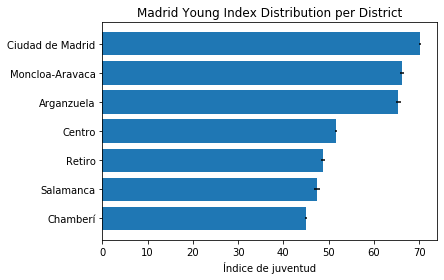

In [38]:
# step 1: get the data
df_districts = districts_3km[['Distrito','Índice de juventud']]

fig, ax = plt.subplots()

# Example data
labels = df_districts['Distrito']
y_pos = np.arange(len(labels))
performance = df_districts['Índice de juventud']
error = np.random.rand(len(labels))

ax.barh(y_pos, performance, xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Índice de juventud')
ax.set_title('Madrid Young Index Distribution per District')


plt.show()

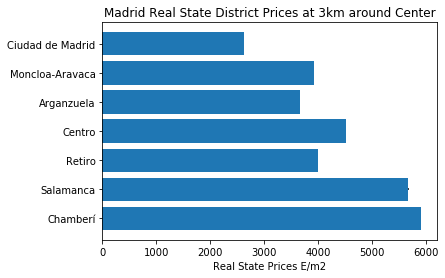

In [39]:
# Graph for Real State
# step 1: get the data
df_districts = districts_3km[['Distrito','ObraNueva (Eur/m2)']]

fig, ax = plt.subplots()

ax.set_yticklabels(labels)

# Example data
labels = df_districts['Distrito']
y_pos = np.arange(len(labels))
xdata = df_districts['ObraNueva (Eur/m2)'] # Xdata
error = np.random.rand(len(labels))

ax.barh(y_pos, xdata, xerr=error, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Real State Prices E/m2')
ax.set_title('Madrid Real State District Prices at 3km around Center')


plt.show()

#### Create two plots, one overlapping the craft-beer locations to the Young Index and another one overlapping the real state prices with the craft-beer locations

In [40]:
craftbeer_map = folium.Map(location=[latitude, longitude], zoom_start=12.7) # generate map centred around Puerta del Sol.


folium.Circle([latitude, longitude], radius=3000, fill=False, color='yellow',popup='<b>3Km Circle</b>').add_to(craftbeer_map)
folium.Circle([latitude, longitude], radius=5000, fill=False, color='red',popup='5Km Circle').add_to(craftbeer_map)

# add a red circle marker to represent the Puerta del Sol (km 0)
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Puerta del Sol',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(craftbeer_map)

# add the Breweries as blue circle markers
for lat, lng, label in zip(craft_beer.lat, craft_beer.lng, craft_beer.categories):
    folium.features.CircleMarker( 
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(craftbeer_map)

# Generate Markers for the centers of the districts 
for lat, lon, label in zip(districts_3km.lat, districts_3km.lon, districts_3km.Distrito):
    folium.features.CircleMarker(
        [lat, lon],
        radius=5,
        color='green',
        popup=label,
        fill = True,
        fill_color='green',
        fill_opacity=0.8
    ).add_to(craftbeer_map)

# generate choropleth map using the Indice de Juventud "Young Index"
craftbeer_map.choropleth(
    geo_data=madrid_districts_geo,
    data=districts_3km,
    columns=['Distrito','Índice de juventud'],
    key_on='feature.properties.name',
    fill_color='YlGn', 
    fill_opacity= 0.5, 
    line_opacity= 0.2,
    legend_name = 'Young Index'
)

# display map
craftbeer_map

In [41]:
craftbeer_map2 = folium.Map(location=[latitude, longitude], zoom_start=12.7) # generate map centred around Puerta del Sol.

folium.Circle([latitude, longitude], radius=3000, fill=False, color='yellow').add_to(craftbeer_map2)
folium.Circle([latitude, longitude], radius=5000, fill=False, color='red').add_to(craftbeer_map2)

# add a red circle marker to represent the Puerta del Sol (km 0)
folium.features.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Puerta del Sol',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(craftbeer_map2)

# add the Breweries as blue circle markers
for lat, lng, label in zip(craft_beer.lat, craft_beer.lng, craft_beer.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(craftbeer_map2)
    
# Generate Markers for the centers of the districts 
for lat, lon, label in zip(districts_3km.lat, districts_3km.lon, districts_3km.Distrito):
    folium.features.CircleMarker(
        [lat, lon],
        radius=5,
        color='green',
        popup=label,
        fill = True,
        fill_color='green',
        fill_opacity=0.8
    ).add_to(craftbeer_map2)
    
# generate choropleth map using the "Precio de Obra Nueva" real-state prices
craftbeer_map2.choropleth(
    geo_data=madrid_districts_geo,
    data=districts_3km,
    columns=['Distrito', 'ObraNueva (Eur/m2)'],
    key_on='feature.properties.name',
    fill_color='YlGnBu', 
    fill_opacity= 0.4, 
    line_opacity= 0.2,
    legend_name = 'Real State prices (Eur/m2)'
)

# display map
craftbeer_map2

## First Conclusions from data wrangling 
#### After the initial data analysis, it looks like that the optimum places for our investors in which we can combine a high Young Index and moderate real state prices are in the border lines around two zones , one between **'Centro' and Moncloa'** districts and another between **Centro and Arganzuela** districts. *Always based on our initial condition of finding this place in a radius of 3km from Madrid City Center*.

## 3. Methodology <a name="Methodology"></a>

In this project we will direct our efforts on detecting areas of Madrid downtown with low number of Craft Beer shops. We will limit our analysis to area ~ 3km around city center.

In first step we have collected the required **data: location and type (category) of every Beer related place within 5km from Madrid center** ("Puerta del Sol). We have also **identified bars or other similar places where beer is sold** (according to Foursquare categorization). But these were removed keeping only breweries and craft-beer shops.

Also we paired this information with Madrid´s City Council information about age distribution and real-state prices.

In the methodology section we will look for the most promising addresses in a 3km circle with a reasonable real-state prices and highest Young Index.

Second step in our analysis will be calculation and exploration of '**craft beer density**' across different areas of Madrid - we will use **heatmaps** to identify a few promising areas close to center with low number of shops in general focus our attention on those areas. Also we will paid attention to the Young Index of the living population on those areas and real-state places to identify the best suitable place to open such a shop

In third and final step we will focus on most promising areas and within those create **clusters of locations that meet some basic requirements** established in discussion with stakeholders: we will take into consideration locations with **no craft beef shops in radius of 500 meters**. We will present map of all such locations but also create clusters (using **k-means clustering**) of those locations to identify general zones / neighborhoods / addresses which should be a starting point for final 'street level' exploration and search for optimal venue location by stakeholders.

## 4. Analysis <a name="Analysis"></a>

##### Let's create another heatmap map showing **heatmap/density of Craft Beer shops and bars**.
##### Overlapped to the boundaries of the districts

In [42]:
cbeer_coords = []
for lat, lng in zip(craft_beer.lat, craft_beer.lng):
    cbeer = (lat,lng)
    cbeer_coords.append((lat,lng)) 

In [43]:
from folium import plugins
from folium.plugins import HeatMap

craftbeer_map3 = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around Puerta del Sol.

folium.Circle([latitude, longitude], radius=3000, fill=False, color='yellow').add_to(craftbeer_map3)
folium.TileLayer('cartodbpositron').add_to(craftbeer_map3) #cartodbpositron cartodbdark_matter
HeatMap(cbeer_coords).add_to(craftbeer_map3)
folium.Marker([latitude, longitude]).add_to(craftbeer_map3)

craftbeer_map3.choropleth(
    geo_data=madrid_districts_geo,
    #data=districts_3km,
    #columns=['Distrito','distance_to_center_in_m'],
    key_on='feature.properties.name',
    fill_color='YlGnBu', 
    fill_opacity= 0.1, 
    line_opacity= 0.4,
    #legend_name = ''
)

craftbeer_map3

#### Moncloa and Arganzuela District Candidates.

It can be seen that this kind of business is not as saturated with offers for such a big city like Madrid.
Borders of Moncloa and Arganzuela districts look as the most promising places in terms of low density of Craft Breweries combined with moderate real-state prices and mid-age population index so high probability of potential customers. However there are zones in the border between Centro and Moncloa which are close to the Real Palace or Casa de Campo where there aren´t commercial places to open such kind of business.

In terms of **turism fluency** and business oppotunity the **places near Princesa Street and Calle de Segovia** represent some interesting pocket zones where it could be attractive to open such a shop.


#### Let´s define these two zones of interest Region of Interest 1 (ROI_1) for Princesa Street Zone and ROI_2 for Segovia Street 

In [44]:
address_roi1 = 'Calle de Princesa 2, Madrid'

geolocator_roi1 = Nominatim(user_agent="foursquare_agent")
location_roi1 = geolocator_roi1.geocode(address_roi1)
latitude_roi1 = location_roi1.latitude
longitude_roi1 = location_roi1.longitude

address_roi2 = 'Calle de Manzanares 5, Madrid'

geolocator_roi2 = Nominatim(user_agent="foursquare_agent")
location_roi2 = geolocator_roi2.geocode(address_roi2)
latitude_roi2 = location_roi2.latitude
longitude_roi2 = location_roi2.longitude

print(latitude_roi1, longitude_roi1)
print(latitude_roi2, longitude_roi2)

40.4246926 -3.7117891
40.412837 -3.7194574


In [45]:
roi_center_1 = [latitude_roi1, longitude_roi1]
roi_center_2 = [latitude_roi2, longitude_roi2]

map_Madrid_1 = folium.Map(location=roi_center_1, zoom_start=13.8)
HeatMap(cbeer_coords).add_to(map_Madrid_1)
folium.Marker([latitude, longitude]).add_to(map_Madrid_1)
folium.Circle(roi_center_1, radius=500, color='white', fill=True, fill_opacity=0.2).add_to(map_Madrid_1)
#folium.Circle(roi_center_1, radius=1000, color='white', fill=True, fill_opacity=0.4).add_to(map_Madrid_1)
folium.Circle(roi_center_2, radius=500, color='green', fill=True, fill_opacity=0.2).add_to(map_Madrid_1)
#folium.Circle(roi_center_2, radius=1000, color='green', fill=True, fill_opacity=0.3).add_to(map_Madrid_1)
map_Madrid_1

#### Find Candidates for ROI_1

In [46]:
roi_center_x1, roi_center_y1 = lonlat_to_xy(longitude_roi1, latitude_roi1)
roi_center_x2, roi_center_y2 = lonlat_to_xy(longitude_roi2, latitude_roi2)

In [47]:
roi_x_min1 = roi_center_x1 - 500
roi_y_max1 = roi_center_y1 + 500
roi1_width = 1000
roi1_height = 1000
#roi_center_x1 = roi_x_min1 + 2500
#roi_center_y1 = roi_y_max1 - 2500
roi_center1 = [latitude_roi1, longitude_roi1]

k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_step = 200
y_step = 200 * k 
roi_y_min1 = roi_center_y1 - 500

roi_latitudes1 = []
roi_longitudes1 = []
roi_xs1 = []
roi_ys1 = []
for i in range(0, int(51/k)):
    y1 = roi_y_min1 + i * y_step
    x_offset = 50 if i%2==0 else 0
    for j in range(0, 51):
        x1 = roi_x_min1 + j * x_step + x_offset
        d1 = calc_xy_distance(roi_center_x1, roi_center_y1, x1, y1)
        if (d1 <= 501):
            lon, lat = xy_to_lonlat(x1, y1)
            roi_latitudes1.append(lat)
            roi_longitudes1.append(lon)
            roi_xs1.append(x1)
            roi_ys1.append(y1)

print(len(roi_latitudes1), 'candidate neighborhood centers generated.')

24 candidate neighborhood centers generated.


#### Find Candidates for ROI_2

In [48]:
roi_x_min2 = roi_center_x2 - 500
roi_y_max2 = roi_center_y2 + 500
roi_width2 = 1000
roi_height2 = 1000
#roi_center_x2 = roi_x_min2 + 2500
#roi_center_y2 = roi_y_max2 - 2500
roi_center2 = [latitude_roi2, longitude_roi2]

k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_step = 200
y_step = 200 * k 
roi_y_min2 = roi_center_y2 - 500

roi_latitudes2 = []
roi_longitudes2 = []
roi_xs2 = []
roi_ys2 = []
for i in range(0, int(51/k)):
    y2 = roi_y_min2 + i * y_step
    x_offset = 50 if i%2==0 else 0
    for j in range(0, 51):
        x2 = roi_x_min2 + j * x_step + x_offset
        d2 = calc_xy_distance(roi_center_x2, roi_center_y2, x2, y2)
        if (d2 <= 501):
            lon2, lat2 = xy_to_lonlat(x2, y2)
            roi_latitudes2.append(lat2)
            roi_longitudes2.append(lon2)
            roi_xs2.append(x2)
            roi_ys2.append(y2)

print(len(roi_latitudes2), 'candidate neighborhood centers generated.')

24 candidate neighborhood centers generated.


#### Let´s find if there are Craft Beer places near the locations for ROI_1 and ROI_2

In [49]:
# Let´s find the X,Y from the coordinates of the Craft Beer places
cb_lat = craft_beer['lat'].values
cb_lon = craft_beer['lng'].values

In [50]:
craft_x =[]
craft_y =[]

for lon,lat in zip(cb_lon,cb_lat):
    x_craft,y_craft = lonlat_to_xy(lon,lat)
    craft_x.append(x_craft)
    craft_y.append(y_craft)
    
#craft_xy = (craft_x,craft_y)


In [51]:
def find_nearest_craft_beer(x, y, craftx,crafty):
    # Distance limit among craft beer shops contraint
    d_min = 500
    for c1 in range(len(craftx)):
        c_x = craftx[c1]; c_y = crafty[c1]
        d = calc_xy_distance(x, y, c_x, c_y)
        if d<=d_min:
            d_min = d
    return d_min

roi1_craft_distances = []
roi2_craft_distances = []

print('Generating data on location candidates... ', end='')

for x, y in zip(roi_xs1, roi_ys1):
    distance1 = find_nearest_craft_beer(x, y, craft_x,craft_y)
    roi1_craft_distances.append(distance1)
print('done for ROI_1')

for x, y in zip(roi_xs2, roi_ys2):
    distance2 = find_nearest_craft_beer(x, y, craft_x,craft_y)
    roi2_craft_distances.append(distance2)
print('done for ROI_2')


Generating data on location candidates... done for ROI_1
done for ROI_2


In [52]:
# Let's put this into dataframes
df_roi1_loc = pd.DataFrame({'Latitude':roi_latitudes1,
                            'Longitude':roi_longitudes1,
                            'X':roi_xs1,
                            'Y':roi_ys1,
                            'Distance to Craft_Beer':roi1_craft_distances})
df_roi2_loc = pd.DataFrame({'Latitude':roi_latitudes2,
                            'Longitude':roi_longitudes2,
                            'X':roi_xs2,
                            'Y':roi_ys2,
                            'Distance to Craft_Beer':roi2_craft_distances})

We are going to filter now those locations: we're interested only in locations with no Craft Beer Shops in a radius of 500 meters.

In [53]:
ok_shop1_dist_BB = np.array(df_roi1_loc['Distance to Craft_Beer']>=500)
ok_shop2_dist_BB = np.array(df_roi2_loc['Distance to Craft_Beer']>=500)

print('Locations with no Craft_Beer within 500m for ROI_1:', ok_shop1_dist_BB.sum())
print('Locations with no Craft_Beer within 500m for ROI_2:', ok_shop2_dist_BB.sum())

Locations with no Craft_Beer within 500m for ROI_1: 12
Locations with no Craft_Beer within 500m for ROI_2: 23


In [54]:
craft_good_locs_1 = df_roi1_loc[ok_shop1_dist_BB]
craft_good_locs_2 = df_roi2_loc[ok_shop2_dist_BB]

#### Plot for interesting points in ROI_1

In [55]:
craft_good_latitudes1 = craft_good_locs_1['Latitude'].values
craft_good_longitudes1 = craft_good_locs_1['Longitude'].values

#craft_good_locs1 = [[lat, lon] for lat, lon in zip(craft_good_latitudes1, craft_good_longitudes1)]

map_Madrid4 = folium.Map(location=roi_center_1, zoom_start=14)
folium.TileLayer('cartodbpositron').add_to(map_Madrid4)
HeatMap(cbeer_coords).add_to(map_Madrid4)
folium.Marker([latitude, longitude]).add_to(map_Madrid4)
folium.Circle(roi_center_1, radius=500, color='red', fill=True, fill_opacity=0.2).add_to(map_Madrid4)
#folium.Circle(roi_center_2, radius=500, color='green', fill=True, fill_opacity=0.2).add_to(map_Madrid4)

for lat, lon in zip(craft_good_latitudes1, craft_good_longitudes1):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=0.4).add_to(map_Madrid4) 

map_Madrid4

#### Plot for interesting points in ROI_2

In [56]:
craft_good_latitudes2 = craft_good_locs_2['Latitude'].values
craft_good_longitudes2 = craft_good_locs_2['Longitude'].values

craft_good_locs2 = [[lat, lon] for lat, lon in zip(craft_good_latitudes2, craft_good_longitudes2)]

map_Madrid5 = folium.Map(location=roi_center_2, zoom_start=14)
folium.TileLayer('cartodbpositron').add_to(map_Madrid5)
HeatMap(cbeer_coords).add_to(map_Madrid4)
folium.Marker([latitude, longitude]).add_to(map_Madrid5)
folium.Circle(roi_center_2, radius=500, color='green', fill=True, fill_opacity=0.2).add_to(map_Madrid5)

for lat, lon in zip(craft_good_latitudes2, craft_good_longitudes2):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=0.4).add_to(map_Madrid5) 

map_Madrid5

### k-means initialization <a name="k-means"></a>
#### We have 2 clusters one for breweries and another for beer shops

Looking good. What we have now is a clear indication of zones with low number of restaurants in vicinity, and *no* Italian restaurants at all nearby.

Let us now **cluster** those locations to create **centers of zones containing good locations**. Those zones, their centers and addresses will be the final result of our analysis. 

In [57]:
# For ROI 1
number_of_clusters = 8

good_xys_roi1 = craft_good_locs_1[['X', 'Y']].values
kmeans_roi1 = KMeans(n_clusters=number_of_clusters, random_state=0).fit(good_xys_roi1)

cluster_centers_roi1 = [xy_to_lonlat(cc[0], cc[1]) for cc in kmeans_roi1.cluster_centers_]


In [58]:
map_Madrid6 = folium.Map(location=roi_center_1, zoom_start=14)
folium.TileLayer('cartodbpositron').add_to(map_Madrid6)
HeatMap(cbeer_coords).add_to(map_Madrid6)
folium.Marker([latitude, longitude]).add_to(map_Madrid6)

for lat, lon in zip(craft_good_latitudes1, craft_good_longitudes1):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=0.4).add_to(map_Madrid6) 
for lon, lat in cluster_centers_roi1:
    folium.Circle([lat, lon], radius=400, color='green', fill=True, fill_opacity=0.25).add_to(map_Madrid6) 

map_Madrid6

In [59]:
# For ROI 2
number_of_clusters = 8

good_xys_roi2 = craft_good_locs_2[['X', 'Y']].values
kmeans_roi2 = KMeans(n_clusters=number_of_clusters, random_state=0).fit(good_xys_roi2)

cluster_centers_roi2 = [xy_to_lonlat(cc[0], cc[1]) for cc in kmeans_roi2.cluster_centers_]


In [60]:
map_Madrid7 = folium.Map(location=roi_center_2, zoom_start=14)
folium.TileLayer('cartodbpositron').add_to(map_Madrid7)
HeatMap(cbeer_coords).add_to(map_Madrid7)
folium.Marker([latitude, longitude]).add_to(map_Madrid7)

for lat, lon in zip(craft_good_latitudes2, craft_good_longitudes2):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=0.4).add_to(map_Madrid7) 
for lon, lat in cluster_centers_roi2:
    folium.Circle([lat, lon], radius=400, color='green', fill=True, fill_opacity=0.2).add_to(map_Madrid7) 

map_Madrid7

Finaly, let's **reverse geocode those candidate area centers to get the addresses** which can be presented to stakeholders. On every ROI

In [140]:
del candidate_area_addresses_ROI1
candidate_area_addresses_ROI1 = []
print('===========================================================================')
print('Addresses of centers of areas recommended for further analysis around ROI 1')
print('===========================================================================\n')
for lon, lat in cluster_centers_roi1 :
    addr_roi1 = get_address(lat, lon)
    candidate_area_addresses_ROI1.append(addr_roi1)    
    d_roi1 = calc_distance_geopy(lat, lon, latitude, longitude)
    print('{} => {:.1f}km from Puerta del Sol'.format(' '*(30-len(candidate_area_addresses_ROI1)), d_roi1/1000))
  

Addresses of centers of areas recommended for further analysis around ROI 1

Parroquia de Santa Teresa y San José, 14, Plaza de España, Moncloa-Aravaca, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28008, España
(40.4223911, -3.71489809633472)
                              => 1.1km from Puerta del Sol
4-6, Paseo del Pintor Rosales, Plaza de España, Moncloa-Aravaca, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28008, España
(40.4254744, -3.7174201)
                             => 1.5km from Puerta del Sol
28, Calle de Fomento, Palacio, Centro, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28013, España
(40.4217175, -3.7107406)
                            => 0.8km from Puerta del Sol
One to one, Calle de Tutor, Plaza de España, Moncloa-Aravaca, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España
(40.4276568, -3.7153744)
                

In [147]:
del candidate_area_addresses_ROI2
candidate_area_addresses_ROI2 = []
print('===========================================================================')
print('Addresses of centers of areas recommended for further analysis around ROI 2')
print('===========================================================================\n')
for lon, lat in cluster_centers_roi2 :
    addr_roi2 = get_address(lat, lon)
    candidate_area_addresses_ROI2.append(addr_roi2)    
    d_roi2 = calc_distance_geopy(lat, lon, latitude, longitude)
    print('{}{} => {:.1f}km from Puerta del Sol'.format(candidate_area_addresses_ROI2, ' '*(50-len(candidate_area_addresses_ROI2)), d_roi2/1000))

Addresses of centers of areas recommended for further analysis around ROI 2

4, Calle de Pablo Casals, Latina, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28011, España
(40.41127945, -3.72456477193784)
['4, Calle de Pablo Casals, Latina, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28011, España']                                                  => 1.8km from Puerta del Sol
Jardines del Campo del Moro, Paseo de los Civiles, Palacio, Centro, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España
(40.41807565, -3.71777012258418)
['4, Calle de Pablo Casals, Latina, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28011, España', 'Jardines del Campo del Moro, Paseo de los Civiles, Palacio, Centro, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España']                                                 =>

In [142]:
candidate_area_addresses_ROI1
#candidate_area_addresses_ROI2.to_clipboard('candidate_area_addresses_ROI2.csv')  

['Parroquia de Santa Teresa y San José, 14, Plaza de España, Moncloa-Aravaca, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28008, España',
 '4-6, Paseo del Pintor Rosales, Plaza de España, Moncloa-Aravaca, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28008, España',
 '28, Calle de Fomento, Palacio, Centro, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28013, España',
 'One to one, Calle de Tutor, Plaza de España, Moncloa-Aravaca, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España',
 'Monumento a Cervantes, Plaza de España, Moncloa-Aravaca, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España',
 'Calle Profesor Martín Almagro Bash, Plaza de España, Moncloa-Aravaca, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España',
 'Suites Viena, 17, Calle de Ju

In [143]:
del candidate_area_addresses_ROI1[0]
candidate_area_addresses_ROI1

['4-6, Paseo del Pintor Rosales, Plaza de España, Moncloa-Aravaca, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28008, España',
 '28, Calle de Fomento, Palacio, Centro, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28013, España',
 'One to one, Calle de Tutor, Plaza de España, Moncloa-Aravaca, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España',
 'Monumento a Cervantes, Plaza de España, Moncloa-Aravaca, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España',
 'Calle Profesor Martín Almagro Bash, Plaza de España, Moncloa-Aravaca, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España',
 'Suites Viena, 17, Calle de Juan Álvarez Mendizábal, Plaza de España, Moncloa-Aravaca, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28008, España',
 'Carmina, 58, Gran V

In [144]:
del candidate_area_addresses_ROI1[6]
candidate_area_addresses_ROI1

['4-6, Paseo del Pintor Rosales, Plaza de España, Moncloa-Aravaca, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28008, España',
 '28, Calle de Fomento, Palacio, Centro, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28013, España',
 'One to one, Calle de Tutor, Plaza de España, Moncloa-Aravaca, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España',
 'Monumento a Cervantes, Plaza de España, Moncloa-Aravaca, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España',
 'Calle Profesor Martín Almagro Bash, Plaza de España, Moncloa-Aravaca, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España',
 'Suites Viena, 17, Calle de Juan Álvarez Mendizábal, Plaza de España, Moncloa-Aravaca, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28008, España']

In [148]:
candidate_area_addresses_ROI2

['4, Calle de Pablo Casals, Latina, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28011, España',
 'Jardines del Campo del Moro, Paseo de los Civiles, Palacio, Centro, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España',
 'Tecnocasa, 69, Calle de Segovia, Palacio, Centro, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28005, España',
 'El Mejidroño, Calle de Juan Duque, Imperial, Centro, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España',
 'Calle 30, Imperial, Centro, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España',
 'La Violetera, Plaza Gabriel Miró, Palacio, Centro, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España',
 'Calle 30, Latina, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España'

In [149]:
del candidate_area_addresses_ROI2[1]
candidate_area_addresses_ROI2

['4, Calle de Pablo Casals, Latina, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28011, España',
 'Tecnocasa, 69, Calle de Segovia, Palacio, Centro, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28005, España',
 'El Mejidroño, Calle de Juan Duque, Imperial, Centro, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España',
 'Calle 30, Imperial, Centro, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España',
 'La Violetera, Plaza Gabriel Miró, Palacio, Centro, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España',
 'Calle 30, Latina, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España',
 'La Fogata, Paseo de la Ermita del Santo, Latina, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España']

In [151]:
del candidate_area_addresses_ROI2[3]
candidate_area_addresses_ROI2

['4, Calle de Pablo Casals, Latina, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28011, España',
 'Tecnocasa, 69, Calle de Segovia, Palacio, Centro, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28005, España',
 'El Mejidroño, Calle de Juan Duque, Imperial, Centro, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España',
 'La Violetera, Plaza Gabriel Miró, Palacio, Centro, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España',
 'Calle 30, Latina, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España',
 'La Fogata, Paseo de la Ermita del Santo, Latina, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España']

In [153]:
del candidate_area_addresses_ROI2[5]
candidate_area_addresses_ROI2

['4, Calle de Pablo Casals, Latina, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28011, España',
 'Tecnocasa, 69, Calle de Segovia, Palacio, Centro, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28005, España',
 'El Mejidroño, Calle de Juan Duque, Imperial, Centro, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España',
 'La Violetera, Plaza Gabriel Miró, Palacio, Centro, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España',
 'Calle 30, Latina, Madrid, Área metropolitana de Madrid y Corredor del Henares, Comunidad de Madrid, 28001, España']

In [154]:
map_Madrid8 = folium.Map(location=[latitude, longitude], zoom_start=14.5)
folium.Circle([latitude, longitude], radius=50, color='red', fill=True, fill_opacity=1).add_to(map_Madrid8) 
for lonlat, addr in zip(cluster_centers_roi1, candidate_area_addresses_ROI1):
    folium.Marker([lonlat[1], lonlat[0]], popup=addr).add_to(map_Madrid8) 

for lonlat, addr in zip(cluster_centers_roi2, candidate_area_addresses_ROI2):
    folium.Marker([lonlat[1], lonlat[0]], popup=addr).add_to(map_Madrid8)  

map_Madrid8.choropleth(
    geo_data=madrid_districts_geo,
    #data=districts_3km,
    #columns=['Distrito','distance_to_center_in_m'],
    key_on='feature.properties.name',
    fill_color='YlGnBu', 
    fill_opacity= 0.1, 
    line_opacity= 0.8,
    #legend_name = ''
)
map_Madrid8

This concludes our analysis. We have created 8 addresses per ROI representing centers of places which could be a potential location for a craft-beer shop.  However this study needs further refinement as some of the potential candidates lay-up over public garden addresses or restricted to open such a comercial place because of the lack of locals.
Taken a look to the last map, In the borders of Moncloa district and around calle Manzanares y Arganzuela, arise as highly valuable candidates, because of the above imposed constraints in terms of Young Index and Real State prices. Moreover their good location and good public transport net, make this places good locations to be visited by tourist, then giving chances to be a high profitable place.

## 5. Results and Discussion <a name="Results"></a>

#### As can be seen after the final cleaning of our positions, there can be found suitable places to open craft beer shops in the zones close to the city center, in the some reduced areas close on west Madrid close to tourist areas and were real state prices are below the mean. Latter on it has to be identified if other craft-made products can be sold using this high-valued potential locations.


## 6. Conclusions<a name="Conclusions"></a>

Purpose of this project was to identify Madrid areas with low density of craft beer shops.
Surprisingly the market is not saturated like bars or restaurants, so there exists a high potential for a profitable business of such characteristics.

If we put our attention on districts close to the center with high volume of turists and whose real-state prices are down the mean, the opportunities to be profitable increase. Also a mid to high value for the Young Index population distribution will be a good indicator to open a shop in those districts as young people tend to drink more beer than old people.

